# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021-2022. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet.
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [ ]:
!pip install BeautifulSoup4
!pip install --upgrade gensim
!pip install tqdm

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt') #for tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch, time, copy, os, re, zipfile
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset
from nltk.corpus import stopwords # Import the stop word list
from bs4 import BeautifulSoup
from tqdm import tqdm
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from nltk.tokenize.treebank import TreebankWordDetokenizer #convert back to sentence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [ ]:
songs_df = pd.read_parquet('/content/metrolyrics.parquet')

In [ ]:
def lyrics_to_wordlist(lyrics):
  stops = set(stopwords.words("english"))                  
  # 1. Remove HTML
  lyrics_text = BeautifulSoup(lyrics).get_text() 
  # 2. Remove non-letters        
  letters_only = re.sub("[^a-zA-Z]", " ", lyrics_text) 
  # 3. Convert to lower case, split into individual words
  words = letters_only.lower().split()                             
  # 4. Remove stop words
  words = [w for w in words if not w in stops]
  # 5. Remove words of len = 1
  words = [w for w in words if len(w) > 1] 
  return words

In [ ]:
def lyrics_to_sentences(lyrics, tokenizer):
  # 1. Use the NLTK tokenizer to split the paragraph into sentences
  raw_sentences = tokenizer.tokenize(lyrics.strip())
  # 2. Loop over each sentence
  sentences = []
  for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
      sentences.append(lyrics_to_wordlist(raw_sentence))
  return sentences

In [ ]:
sentences = []  # Initialize an empty list of sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') #load tokenaizer

for lyrics in tqdm(songs_df['lyrics']):
    sentences += lyrics_to_sentences(lyrics, tokenizer)

100%|██████████| 49976/49976 [01:48<00:00, 462.40it/s]


In [ ]:
w2v_model = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=40, window=10, sample=0.001)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [ ]:
w2v_model.wv.most_similar("glass", topn=10)

[('glasses', 0.545772910118103),
 ('cigarettes', 0.5266082286834717),
 ('cup', 0.5214027166366577),
 ('bottle', 0.4910624027252197),
 ('cigarette', 0.4764534533023834),
 ('wine', 0.4599669277667999),
 ('drink', 0.45713675022125244),
 ('bubbles', 0.4554212689399719),
 ('coat', 0.44084179401397705),
 ('ash', 0.4400840699672699)]

In [ ]:
w2v_model.wv.most_similar("dog", topn=10) 

[('hound', 0.6139552593231201),
 ('dogs', 0.542687177658081),
 ('cat', 0.5260366201400757),
 ('barking', 0.49912187457084656),
 ('puppy', 0.46973705291748047),
 ('frog', 0.46819767355918884),
 ('bark', 0.4645535349845886),
 ('leash', 0.46060940623283386),
 ('hog', 0.45781010389328003),
 ('titty', 0.421688973903656)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [ ]:
#Euclidean distance
euc_dist = np.linalg.norm(w2v_model.wv['cat'] - w2v_model.wv['dog'])
print(f'Euclidean distance: {euc_dist}')

#Cosine distance
cosin_dist = w2v_model.wv.distance('cat', 'dog')
print(f'Cosin distance: {cosin_dist}')

Euclidean distance: 13.74511432647705
Cosin distance: 0.4825018644332886


In [ ]:
#Euclidean distance
euc_dist = np.linalg.norm(w2v_model.wv['girl'] - w2v_model.wv['boy'])
print(f'Euclidean distance: {euc_dist}')

#Cosine distance
cosin_dist = w2v_model.wv.distance('girl', 'boy')
print(f'Cosin distance: {cosin_dist}')

Euclidean distance: 19.34150505065918
Cosin distance: 0.6004656851291656


In [ ]:
#Euclidean distance
euc_dist = np.linalg.norm(w2v_model.wv['kitchen'] - w2v_model.wv['child'])
print(f'Euclidean distance: {euc_dist}')

#Cosine distance
cosin_dist = w2v_model.wv.distance('kitchen', 'child')
print(f'Cosin distance: {cosin_dist}')

Euclidean distance: 20.0351619720459
Cosin distance: 1.0025552082806826


### Explanation
As we can see, the cosin distance emphasis the difference between the words in more semantic and realistic way. We can see that when in cosin we get a big distance between kitchen and child but smaller distance between boy and girl the euclidean distance gave both of pairs almost the same distance that represent a high difference between the words.
 
The cosine distance measures the difference in orientation. Euclidean distance would also include difference in magnitude, which can tiled the results.
Euclidean distance depends on a vector’s magnitude whereas cosine similarity depends on the angle between the vectors. The angle measure is more resilient to variations of occurrence counts between terms that are semantically similar, whereas the magnitude of vectors are influenced by occurrence counts and heterogeneity of word neighborhood.

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector (the vector you computed using the song lyrics dataset). Split the data to a train and test sets, and report the model performance on both sets.

In [ ]:
with zipfile.ZipFile('/content/SemEval2015-English-Twitter-Lexicon.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

semEval_df = pd.read_csv('/content/SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt', sep="\t", names=['score', 'word'])
semEval_df['word'] = semEval_df['word'].apply(lambda x: x.replace("#", ""))

In [ ]:
def embedd_words(word, w2v_model):
  if word in w2v_model.wv:
      vec = w2v_model.wv[word]
  else:
      vec = np.nan
  return vec

In [ ]:
semEval_df['vec'] = semEval_df['word'].apply(lambda x: embedd_words(x, w2v_model))
semEval_df.dropna(inplace=True)
semEval_df.head()

,score,word,vec
0,0.984,loves,"[0.7401149, -0.07405829, -0.9786648, 0.3482619..."
2,0.969,amazing,"[-0.14017898, 0.9948364, 0.20321341, -0.302035..."
3,0.969,peaceful,"[0.058224306, 0.47973973, -0.031605948, 0.0820..."
4,0.953,greatness,"[0.065673895, 0.025691131, -0.07258512, 0.1741..."
5,0.938,fantastic,"[0.01841742, -0.12527326, -0.6703563, 0.035640..."


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(semEval_df['vec'], semEval_df['score'], test_size=0.2, random_state=42)

In [ ]:
x_train = x_train.to_list()
x_test = x_test.to_list()
y_train = y_train.to_list()
y_test = y_test.to_list()

In [ ]:
regressor = Ridge(alpha=1.0)
regressor.fit(x_train, y_train)
y_pred_test = regressor.predict(x_test)
y_pred_train = regressor.predict(x_train)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Train's MSE: {round(train_mse, 3)}, Test's MSE: {round(test_mse, 3)}")

Train's MSE: 0.1, Test's MSE: 0.308


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [ ]:
words_sentiment_dataset = semEval_df['word'].to_list()
words_to_predict = set()

for sentence in sentences:
  for word in sentence:
    if word not in words_sentiment_dataset:
      words_to_predict.add(word)

In [ ]:
songs_words_df = pd.DataFrame (list(words_to_predict), columns = ['word'])
songs_words_df['vec'] = songs_words_df['word'].apply(lambda x: embedd_words(x))
songs_words_df.dropna(inplace=True)
songs_words_df.head()

,word,vec
2,emptied,"[-0.04991555, 0.111111514, -0.0933969, -0.0057..."
5,willst,"[-0.31290576, 0.21449652, 0.027861625, 0.01759..."
16,showed,"[0.5535033, -0.26419467, 0.37930772, -0.242182..."
22,length,"[0.028374622, 0.16176198, -0.010871219, 0.1193..."
28,sock,"[-0.073550895, 0.14726068, -0.037020065, -0.31..."


In [ ]:
y_pred_songs_words = regressor.predict(songs_words_df['vec'].to_list())
songs_words_df['predict'] = y_pred_songs_words

In [ ]:
songs_words_df.nlargest(20, 'predict')

,word,vec,predict
154362,x,"[-1.6942222, 0.26493186, -0.48919994, 0.974095...",3.028060
6098,open,"[-1.2158725, 0.8688985, -0.4617153, 0.6208076,...",1.981404
125615,bout,"[-0.71366096, -2.6343246, -1.0406893, -1.27515...",1.929348
42054,bridge,"[-0.46698087, -0.42774394, -0.9764119, 0.18463...",1.910813
89713,yea,"[-0.7285925, 0.3835624, -0.4243212, 0.766829, ...",1.908716
31237,much,"[1.0826589, -0.9480849, -0.15542634, 0.5437311...",1.762600
98745,light,"[-0.77690023, 1.0672016, -2.2604625, -0.066012...",1.720260
137177,reach,"[0.62135845, 0.96689326, 0.59912854, -0.190527...",1.718757
168944,mi,"[0.5913791, -1.4516606, -0.2190254, 0.09258544...",1.702437
57794,sun,"[-0.07322957, -0.51312315, -1.8508846, -0.4406...",1.702116


In [ ]:
songs_words_df.nsmallest(20, 'predict')

,word,vec,predict
112334,door,"[1.0624056, -0.8748254, -2.2617047, -1.119261,...",-2.071878
51724,tryin,"[1.099934, 0.48463523, 0.7931942, -0.49095106,...",-1.730380
138080,sich,"[-0.670998, 0.56891894, -0.41597754, 0.3602499...",-1.713755
78931,tat,"[-0.5003692, -0.812688, 0.86647654, -0.2153842...",-1.628967
163263,trouble,"[1.0030403, -1.2224668, 0.91359526, 0.39963052...",-1.612957
66107,wa,"[-2.411508, 1.596554, -0.63833076, 2.3745656, ...",-1.560258
2132,wo,"[-1.74624, 0.69874716, -0.46242616, 1.1338048,...",-1.544207
24251,away,"[0.8974874, -1.3153924, -0.58873045, -0.605968...",-1.539509
24693,dead,"[-1.7767199, -0.92078394, -0.7597481, -1.15308...",-1.530548
120860,ga,"[-2.025575, 1.8772645, -0.6183134, 2.62474, -1...",-1.529499


#### Review the words
As we can see, some of the results are make sense. If we look at the top 20 negative sentiment words, we can see that there are words like- death, bloody, "eu", bitter, killing that got an high negative score. 

We can say the same thing on the top 20 positive sentiment words, there we can find words like- believe, together, shining, heaven that have a positive sentimente. 

But in both lists we can see words that desn't related to the sentiment list like- door, punk, doin that might got a vector that it's closet to the positive/negative sentiment words because they shows up in sentences with positive
/negative sentiment words in the songs so the model got confused.

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. You are encouraged to try that color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [ ]:
from collections import Counter
import itertools

full_lyrics = list(itertools.chain.from_iterable(sentences))
counter = Counter(full_lyrics)
most_occur = counter.most_common(3000)
most_occure_dict = dict(most_occur)

In [ ]:
def words_occure_by_genre(genre):
  sentences_by_genre = []  # Initialize an empty list of sentences
  occure_words_genre = {}
  for lyrics in tqdm(songs_df[songs_df['genre'] == genre]['lyrics']):
      sentences_by_genre += lyrics_to_sentences(lyrics, tokenizer)

  lyrics_by_genre = list(itertools.chain.from_iterable(sentences_by_genre))
  counter_genre = Counter(lyrics_by_genre)
  
  for word_genre, counts in counter_genre.items():
    if word_genre in most_occure_dict.keys():
      occure_words_genre[word_genre] = counts
  return occure_words_genre

In [ ]:
def calc_proportion_word_genre(genre, count_words_genre):
  words_in_genre = sum(songs_df[songs_df['genre'] == genre]['num_words'])
  proportions_words = {}
  for word, counts in count_words_genre.items():
    proportions_words[word] = counts/words_in_genre
  return proportions_words

In [ ]:
genres = songs_df['genre'].unique()
geners_counts_occure_words = {}
words_in_lyrics = {}

for genre in genres:
  count_words_genre = words_occure_by_genre(genre)
  print(count_words_genre)
  geners_counts_occure_words[genre] = calc_proportion_word_genre(genre, count_words_genre) 

100%|██████████| 10800/10800 [00:29<00:00, 360.17it/s]


{'spoken': 90, 'saying': 522, 'singing': 484, 'hey': 2926, 'man': 2997, 'dan': 125, 'got': 9714, 'style': 279, 'brother': 206, 'never': 8388, 'dressed': 128, 'without': 2146, 'smile': 1125, 'clothes': 289, 'may': 911, 'stand': 1176, 'mile': 62, 'cares': 170, 'wearing': 115, 'main': 79, 'street': 455, 'row': 44, 'wear': 262, 'ear': 131, 'head': 1506, 'toe': 37, 'matters': 130, 'long': 2537, 'remember': 1258, 'sister': 180, 'ready': 1382, 'goes': 916, 'listen': 778, 'toes': 67, 'ah': 1886, 'lovely': 140, 'sisters': 66, 'doo': 413, 'oo': 270, 'bother': 79, 'l': 1903, 'three': 492, 'e': 2392, 'ya': 3066, 'could': 5018, 'cause': 7759, 'much': 2328, 'pain': 1091, 'leave': 2085, 'heart': 6427, 'rain': 1055, 'gave': 888, 'everything': 2454, 'oh': 17682, 'tell': 4860, 'lies': 642, 'put': 1987, 'tears': 1023, 'eyes': 3240, 'push': 279, 'world': 4166, 'good': 3879, 'bye': 280, 'think': 4102, 'someday': 336, 'baby': 11018, 'soon': 477, 'gonna': 5033, 'taste': 372, 'cried': 236, 'right': 5399, 'goi

100%|██████████| 9730/9730 [00:46<00:00, 210.12it/s]


{'chorus': 7203, 'repeat': 905, 'x': 4324, 'even': 4666, 'tryin': 2160, 'low': 1975, 'hoes': 2580, 'cause': 15384, 'game': 4137, 'sure': 1201, 'like': 38574, 'everywhere': 567, 'go': 14326, 'stay': 3510, 'surrounded': 108, 'man': 11546, 'gotta': 6398, 'dough': 748, 'got': 26595, 'verse': 4211, 'one': 11961, 'cent': 293, 'makin': 1096, 'hits': 383, 'try': 3278, 'act': 1202, 'heard': 1812, 'shit': 14699, 'see': 13912, 'come': 10274, 'door': 1196, 'bitches': 3635, 'changed': 605, 'know': 24492, 'blow': 1831, 'drink': 1138, 'till': 1907, 'fall': 1517, 'jump': 1035, 'nigga': 17089, 'goin': 2643, 'club': 1949, 'niggaz': 3197, 'ball': 1069, 'punk': 614, 'ass': 6262, 'dance': 1744, 'floor': 1221, 'crawl': 103, 'shots': 866, 'big': 4516, 'enough': 1573, 'tear': 472, 'fuckin': 3001, 'wall': 749, 'range': 323, 'rims': 293, 'bad': 3043, 'luck': 320, 'rap': 2795, 'feelings': 306, 'hear': 2905, 'killin': 435, 'haha': 289, 'yeah': 12957, 'fuck': 11607, 'thought': 1848, 'giving': 396, 'motherfuckin': 

100%|██████████| 11733/11733 [00:30<00:00, 391.02it/s]


{'vision': 135, 'room': 680, 'come': 5810, 'decision': 60, 'dog': 391, 'day': 4187, 'breaking': 283, 'think': 3425, 'realize': 241, 'walk': 1452, 'disguise': 130, 'looking': 1280, 'truth': 922, 'set': 696, 'free': 1281, 'need': 3551, 'somebody': 685, 'push': 276, 'gravity': 76, 'kiss': 1018, 'sun': 1714, 'take': 5376, 'trip': 143, 'freedom': 281, 'wisdom': 62, 'guide': 99, 'world': 3983, 'keep': 2847, 'turnin': 60, 'spirit': 210, 'deep': 772, 'inside': 2075, 'wanna': 2544, 'darkest': 93, 'good': 3123, 'faith': 394, 'hands': 1189, 'wind': 750, 'pretending': 86, 'soft': 177, 'blows': 108, 'skin': 494, 'grey': 139, 'matter': 833, 'go': 7397, 'away': 5611, 'see': 7073, 'song': 1272, 'rise': 455, 'strong': 663, 'burns': 170, 'lives': 538, 'one': 7745, 'know': 12114, 'believe': 2051, 'power': 337, 'writing': 97, 'soon': 635, 'wrong': 1421, 'finally': 370, 'gone': 2363, 'forever': 1209, 'put': 1466, 'voice': 552, 'shoot': 268, 'lights': 589, 'moment': 554, 'night': 4194, 'disappear': 189, 'lo

100%|██████████| 8274/8274 [00:12<00:00, 658.76it/s]


{'dont': 197, 'get': 4261, 'much': 1702, 'feels': 355, 'like': 7504, 'sky': 726, 'clear': 228, 'sun': 1220, 'bright': 418, 'aint': 79, 'looking': 611, 'forward': 30, 'night': 3526, 'cuz': 65, 'cold': 919, 'chill': 42, 'im': 182, 'gonna': 3660, 'feel': 1872, 'sorry': 285, 'know': 7305, 'fault': 65, 'mine': 1391, 'guess': 869, 'theres': 63, 'nothing': 1174, 'left': 1602, 'try': 917, 'pack': 146, 'bags': 35, 'cannot': 176, 'deny': 44, 'last': 1502, 'goodbye': 836, 'always': 2245, 'tough': 156, 'times': 860, 'without': 968, 'getting': 408, 'burned': 167, 'took': 963, 'granted': 50, 'said': 2760, 'never': 4894, 'leave': 1393, 'turned': 525, 'walk': 1108, 'away': 2967, 'told': 854, 'loved': 806, 'time': 5523, 'late': 607, 'close': 796, 'door': 991, 'begin': 97, 'cry': 1207, 'think': 2288, 'found': 1100, 'way': 4572, 'back': 4489, 'home': 3000, 'loose': 120, 'many': 854, 'things': 1642, 'love': 12111, 'grow': 429, 'missed': 153, 'days': 960, 'kid': 210, 'fear': 183, 'became': 65, 'shadow': 81

100%|██████████| 9439/9439 [00:26<00:00, 354.24it/s]


{'found': 634, 'yet': 602, 'look': 1572, 'glass': 185, 'turn': 1156, 'head': 1318, 'moving': 195, 'lane': 32, 'inside': 2229, 'town': 185, 'london': 14, 'crowd': 120, 'much': 873, 'top': 224, 'mental': 136, 'saw': 432, 'simple': 113, 'fact': 128, 'seemed': 74, 'clear': 357, 'bed': 271, 'dark': 1757, 'legs': 104, 'dead': 2383, 'pen': 48, 'going': 678, 'get': 2698, 'dying': 673, 'still': 2174, 'warm': 189, 'put': 715, 'writing': 52, 'spit': 160, 'breath': 685, 'dear': 170, 'destiny': 411, 'mill': 10, 'shall': 1121, 'make': 2384, 'us': 2998, 'strong': 598, 'l': 294, 'lado': 10, 'el': 739, 'dame': 42, 'ya': 518, 'tengo': 54, 'ese': 25, 'del': 208, 'los': 227, 'son': 540, 'mis': 60, 'de': 1193, 'soy': 71, 'tu': 366, 'c': 192, 'mo': 89, 'que': 962, 'hay': 80, 'pero': 65, 'una': 137, 'tiene': 19, 'bien': 44, 'porque': 38, 'te': 349, 'say': 2039, 'march': 218, 'tune': 68, 'right': 1689, 'rules': 239, 'name': 1002, 'christ': 292, 'leader': 86, 'hotel': 18, 'room': 291, 'smoking': 36, 'cock': 57

In [ ]:
text_counts_occure_words = {}
total_words = sum(songs_df['num_words'])
for word, counts in most_occure_dict.items():
  text_counts_occure_words[word] = counts/total_words

In [ ]:
proportional_words = {}
for genre in genres:
  proportional_words[genre] = {}
  for word, genre_prop in geners_counts_occure_words[genre].items():
    text_prop = text_counts_occure_words[word]
    proportion = genre_prop/text_prop
    proportional_words[genre][word] = proportion
  sorted_genre = [word for word, val in sorted(proportional_words[genre].items(), key=lambda item: item[1])]
  proportional_words[genre] = sorted_genre[-50:]

In [ ]:
words_list = []

for genre in genres:
  words_list += proportional_words[genre]

top_significant_words = list(set(words_list))

In [ ]:
from gensim.utils import dict_from_corpus
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def tsnescatterplot(model, proportional_words):
    arrays = np.empty((0, 300), dtype='f')
    colors = {'Pop': 'purple', 
              'Hip-Hop': 'blue', 
              'Rock': 'black', 
              'Country': 'green', 
              'Metal': 'red'}
    word_labels = []
    color_list = []
    frames = []
    y_df = None

    for genre in genres:
      list_words = proportional_words[genre]
      color_name = colors[genre]
      # adds the vector for each of the words from list_names to the array
      for word in list_words:
          wrd_vector = model.wv.__getitem__([word])
          word_labels.append(word)
          color_list.append(color_name)
          arrays = np.append(arrays, wrd_vector, axis=0)
        
      # Reduces the dimensionality from 300 to 50 dimensions with PCA
      reduc = PCA(n_components=50).fit_transform(arrays)
      
      # Finds t-SNE coordinates for 2 dimensions
      np.set_printoptions(suppress=True)
      
      Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

      if y_df is None:
        y_df = Y
      else:
        np.concatenate((y_df, Y), axis=0)

      # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                              'y': [y for y in Y[:, 1]],
                              'words': word_labels,
                              'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(12, 12)
    
    # Basic plot
    p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                     scatter_kws={'s': 40, 'facecolors': df['color']})
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
    plt.title('t-SNE visualization for songs')
    return df

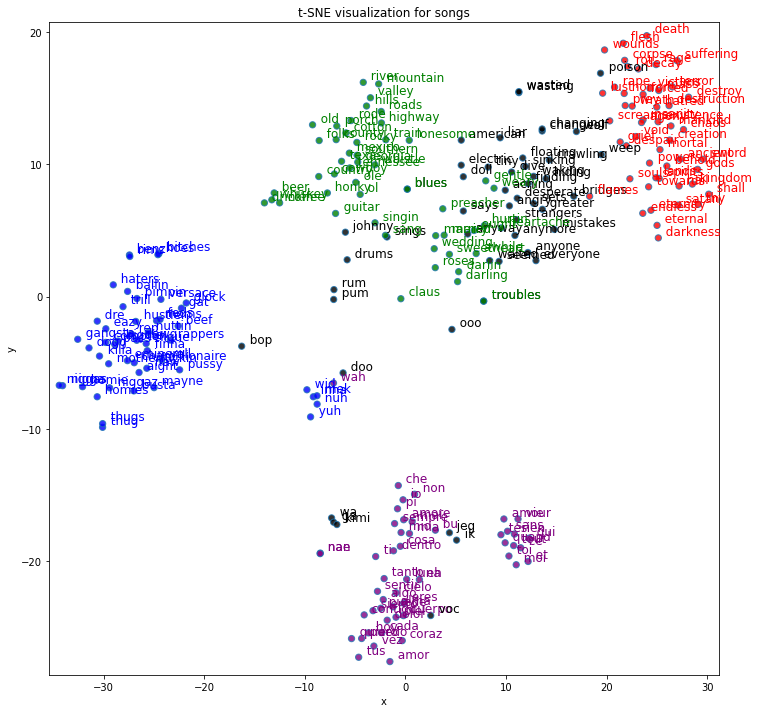

In [ ]:
df = tsnescatterplot(w2v_model, proportional_words)

#### Analyze the results
As we can see from the graph most of the words from the same genre are in the same area and there are some overlapping in areas, we can see that the rock genre represent in area that is between the country and the metal music. In difference we can see that the pop and hip hop are not overlapping with other genres at all. There are some words mostly from the rock music that we can find in other genres, some of those words represent the tune of the music for example: "ooo" those words can be found in each genre.
But some of those words are more common on other genre for example the words poisen and crawling that are more negative sentiment as the other words that we can find in metal music.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [ ]:
# Clean data
songs_df['clean_lyrics'] = songs_df['lyrics'].apply(lambda x: TreebankWordDetokenizer().detokenize(lyrics_to_wordlist(x)))

In [ ]:
# Split train test
X = songs_df['clean_lyrics'].to_numpy()
y = songs_df['genre'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Fit the bag-of-words model
vectorizer = CountVectorizer()
bag = vectorizer.fit(X_train)
messages_bow_train = bag.transform(X_train)
messages_bow_test = bag.transform(X_test)

In [ ]:
# Naive Bayes model
nb_genere = MultinomialNB().fit(messages_bow_train, y_train)
class_names = nb_genere.classes_
y_predict = nb_genere.predict(messages_bow_test)

In [ ]:
print('accuracy', accuracy_score(y_test, y_predict))

accuracy 0.6001280614695054


Show the confusion matrix.

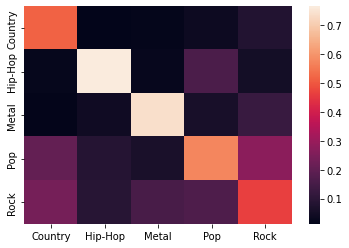

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
num_of_val_examples = sum(conf_matrix, 0)
confusion_matrix_norm = conf_matrix / num_of_val_examples

sns.heatmap(confusion_matrix_norm, xticklabels=class_names, yticklabels=class_names)
plt.show()

Show the classification report - precision, recall, f1 for each class.

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     Country       0.52      0.82      0.63      2069
     Hip-Hop       0.76      0.77      0.77      2417
       Metal       0.74      0.73      0.73      2294
         Pop       0.58      0.33      0.42      2745
        Rock       0.46      0.45      0.46      2969

    accuracy                           0.60     12494
   macro avg       0.61      0.62      0.60     12494
weighted avg       0.61      0.60      0.59     12494



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [ ]:
# Clean data
songs_df['clean_lyrics'] = songs_df['lyrics'].apply(lambda x: TreebankWordDetokenizer().detokenize(lyrics_to_wordlist(x)))

In [ ]:
def get_mean_vector(model, text):
    words = text.lower().split() 
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return []

In [ ]:
mean_vectors = []

for lyrics in tqdm(songs_df['clean_lyrics']):
    vec = get_mean_vector(w2v_model, lyrics)
    mean_vectors.append(vec)

songs_df['mean_vector'] = mean_vectors

100%|██████████| 49976/49976 [00:20<00:00, 2386.72it/s]


In [ ]:
# Split train test
X = songs_df['mean_vector'].to_list()
y = songs_df['genre'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Naive Bayes model
nb_genere_avg_vec = MultinomialNB().fit(X_train, y_train)
class_names = nb_genere_avg_vec.classes_
y_predict = nb_genere_avg_vec.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict))

accuracy 0.47326716824075554


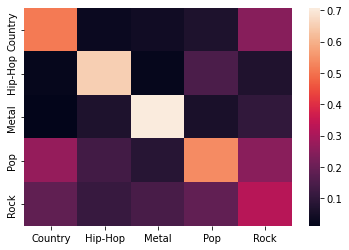

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
num_of_val_examples = sum(conf_matrix, 0)
confusion_matrix_norm = conf_matrix / num_of_val_examples

sns.heatmap(confusion_matrix_norm, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     Country       0.51      0.08      0.14      2069
     Hip-Hop       0.65      0.73      0.69      2417
       Metal       0.71      0.60      0.65      2294
         Pop       0.54      0.16      0.25      2745
        Rock       0.32      0.73      0.45      2969

    accuracy                           0.47     12494
   macro avg       0.55      0.46      0.44     12494
weighted avg       0.54      0.47      0.44     12494



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [ ]:
vectorizer = TfidfVectorizer(min_df=10)
tfidf = vectorizer.fit_transform(songs_df['clean_lyrics'])
train_feature_names = vectorizer.get_feature_names()
tfidf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))

In [ ]:
mean_vectors = []

for lyrics in tqdm(songs_df['clean_lyrics']):
  sent_vec = np.zeros(300)
  weight_sum = 0
  words = lyrics.lower().split()
  for word in words:
    if word in w2v_model.wv.key_to_index and word in train_feature_names:
      vec = w2v_model.wv[word]
      tf_idf = tfidf_dict[word]*(words.count(word)/len(words))
      sent_vec += (vec*tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0:
    sent_vec /= weight_sum
  mean_vectors.append(sent_vec)

songs_df['mean_vector'] = mean_vectors

100%|██████████| 49976/49976 [37:23<00:00, 22.28it/s]


In [ ]:
# Split train test
X = songs_df['mean_vector'].to_list()
y = songs_df['genre'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train_tfidf = scaler.fit_transform(X_train)
X_test_tfidf = scaler.transform(X_test)

In [ ]:
# Naive Bayes model
nb_genere_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
class_names = nb_genere_tfidf.classes_
y_predict = nb_genere_tfidf.predict(X_test_tfidf)

In [ ]:
print('accuracy', accuracy_score(y_test, y_predict))

accuracy 0.4466944133183928


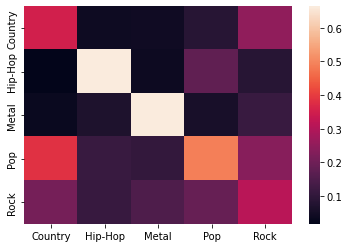

In [ ]:
conf_matrix = confusion_matrix(y_test, y_predict)
num_of_val_examples = sum(conf_matrix, 0)
confusion_matrix_norm = conf_matrix / num_of_val_examples

sns.heatmap(confusion_matrix_norm, xticklabels=class_names, yticklabels=class_names)
plt.show()

In [ ]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     Country       0.35      0.01      0.02      2069
     Hip-Hop       0.66      0.63      0.65      2417
       Metal       0.66      0.55      0.60      2294
         Pop       0.49      0.21      0.30      2745
        Rock       0.31      0.74      0.44      2969

    accuracy                           0.45     12494
   macro avg       0.50      0.43      0.40     12494
weighted avg       0.49      0.45      0.41     12494



### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try to answer this question without using papers or code examples.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper's code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might point you in the right direction for your own code solution.

In [ ]:
# Clean data
songs_df['clean_lyrics'] = songs_df['lyrics'].apply(lambda x: TreebankWordDetokenizer().detokenize(lyrics_to_wordlist(x)))

In [ ]:
#check mods common words
def find_common_words(df):
  fdist = nltk.FreqDist()
  num_words = 0

  for lyrics in tqdm(df['clean_lyrics']):
    words = lyrics.split()
    num_words += len(words)
    for word in words:
      fdist[word] += 1
  common_words = fdist.most_common(num_words)

  vocabulary = dict()
  for idx, word in enumerate(common_words):
      vocabulary[word[0]] = (idx+1) 
  return vocabulary

In [ ]:
def clean_rare_words(df, common_words_dict):
  lyrics_without_rare = []
  for lyrics in tqdm(df['clean_lyrics']):
    clean_lyrics_dict = {}
    words = lyrics.split()
    for word in words:
      if word in common_words_dict.keys() and word not in clean_lyrics_dict.keys():
        clean_lyrics_dict[word] = common_words_dict[word]
        sorted_common_lyrics = list(dict(sorted(clean_lyrics_dict.items(), 
                                             key=lambda item: item[1], reverse=True)).keys())
    lyrics_without_rare.append(np.array(sorted_common_lyrics[:128]))
  return lyrics_without_rare

In [ ]:
common_words_dict = find_common_words(songs_df)
lyrics_without_rare = clean_rare_words(songs_df, common_words_dict)
songs_df['lyrics_without_rare'] = lyrics_without_rare

100%|██████████| 49976/49976 [00:57<00:00, 870.69it/s]


In [ ]:
possible_labels = songs_df['genre'].unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Country': 3, 'Hip-Hop': 1, 'Metal': 4, 'Pop': 0, 'Rock': 2}

In [ ]:
# Split train test
X = songs_df['lyrics_without_rare'].to_numpy()
y = torch.from_numpy(songs_df['genre'].replace(label_dict).to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
class MyDaatset(Dataset):
    def __init__(self, songs_lyrics_list, w2v_model, labels):
        self.songs_lyrics_list = songs_lyrics_list
        self.w2v_model = w2v_model
        self.labels = labels

    def embedd_song(self, lyrics):
        count_songs = 0
        sent_vec = np.zeros((128))
        count_words = 0

        for word in lyrics:
          if word in self.w2v_model.wv.key_to_index:
            sent_vec[count_words] = self.w2v_model.wv.key_to_index[word]
            count_words += 1
        sent_vec[count_words:] = len(self.w2v_model.wv.vectors)
        return sent_vec

    def __getitem__(self, item):
        lyrics = self.songs_lyrics_list[item]
        label = self.labels[item]
        vec_lyrics = torch.from_numpy(self.embedd_song(lyrics))
        return vec_lyrics, label

    def __len__(self):
        return len(self.songs_lyrics_list)

In [ ]:
train_dataset = MyDaatset(X_train, w2v_model, y_train)
test_dataset = MyDaatset(X_test, w2v_model, y_test)

In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
  }

In [ ]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 37482, 'val': 12494}


In [ ]:
#extract embedding weights
vector_size = w2v_model.vector_size
embedding_weights = torch.zeros(len(w2v_model.wv.vectors)+1, vector_size)
embedding_weights[:-1] = torch.FloatTensor(w2v_model.wv.vectors)
embedding_weights[-1] = torch.zeros(vector_size,)

#### W2V embedding weights

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class CnnTextClassifier(nn.Module):
    def __init__(self, embedding_weights, kernel_sizes,dim, num_classes=5, to_freeze=False, random_weights=False):
        super(CnnTextClassifier, self).__init__()
        if random_weights:
          self.embedding = nn.Embedding(embedding_weights.size(0), embedding_weights.size(1))
        else:
          self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=to_freeze, padding_idx=0)

        self.conv_0 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (kernel_sizes[0], dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (kernel_sizes[1], dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (kernel_sizes[2], dim))
        self.fc = nn.Linear(len(kernel_sizes) * 64, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text): #input [B, Index]
        embedded = self.embedding(text) # [B, T, E]
        embedded = embedded.unsqueeze(1) # [B, C, T, E] Add a channel dim.
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3)) # [B, F, T]
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2) # [B, F, 1]
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat_x = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1)) # [B, F, window]
        fc = self.fc(cat_x) # [B, class]
        logits = F.softmax(fc, dim=1) # [B]

        return logits

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = CnnTextClassifier(embedding_weights=embedding_weights, kernel_sizes=[3, 4, 5], dim=300, num_classes=5, to_freeze=False).to(device)
cnn_model

CnnTextClassifier(
  (embedding): Embedding(11431, 300, padding_idx=0)
  (conv_0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=192, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = torch.optim.Adam(cnn_model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = {'train_loss': [], 'test_loss': [],
               'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.long().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #the max probability from each row place 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results['train_loss'].append(epoch_loss)  
                results['train_acc'].append(epoch_acc.item())
            
            else:
              results['test_loss'].append(epoch_loss)
              results['test_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
cnn_model, results = train_model(cnn_model, dataloaders, criterion,optimizer_ft, 
                                 exp_lr_scheduler,num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.3408 Acc: 0.5518
val Loss: 1.3154 Acc: 0.5769

Epoch 1/9
----------
train Loss: 1.2920 Acc: 0.6048
val Loss: 1.2834 Acc: 0.6121

Epoch 2/9
----------
train Loss: 1.2715 Acc: 0.6272
val Loss: 1.2819 Acc: 0.6177

Epoch 3/9
----------
train Loss: 1.2487 Acc: 0.6524
val Loss: 1.2746 Acc: 0.6263

Epoch 4/9
----------
train Loss: 1.2338 Acc: 0.6680
val Loss: 1.2881 Acc: 0.6134

Epoch 5/9
----------
train Loss: 1.2200 Acc: 0.6824
val Loss: 1.2795 Acc: 0.6222

Epoch 6/9
----------
train Loss: 1.2083 Acc: 0.6944
val Loss: 1.2790 Acc: 0.6235

Epoch 7/9
----------
train Loss: 1.1887 Acc: 0.7139
val Loss: 1.2731 Acc: 0.6293

Epoch 8/9
----------
train Loss: 1.1826 Acc: 0.7210
val Loss: 1.2735 Acc: 0.6288

Epoch 9/9
----------
train Loss: 1.1764 Acc: 0.7281
val Loss: 1.2738 Acc: 0.6288

Training complete in 1m 37s
Best val Acc: 0.629342


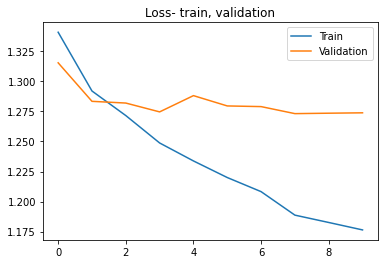

In [ ]:
plt.plot(results['train_loss'], label="Train")
plt.plot(results['test_loss'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

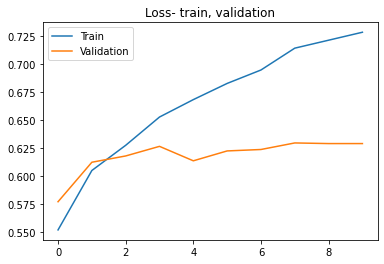

In [ ]:
plt.plot(results['train_acc'], label="Train")
plt.plot(results['test_acc'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

#### W2V embedding freeze weights

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model_freeze = CnnTextClassifier(embedding_weights=embedding_weights, kernel_sizes=[3, 4, 5], dim=300, num_classes=5, to_freeze=True).to(device)
cnn_model_freeze

CnnTextClassifier(
  (embedding): Embedding(11431, 300, padding_idx=0)
  (conv_0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=192, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = torch.optim.Adam(cnn_model_freeze.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
cnn_model_freeze, results = train_model(cnn_model_freeze, dataloaders, criterion,optimizer_ft, 
                                 exp_lr_scheduler,num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.3483 Acc: 0.5443
val Loss: 1.3070 Acc: 0.5884

Epoch 1/9
----------
train Loss: 1.3138 Acc: 0.5827
val Loss: 1.3003 Acc: 0.5983

Epoch 2/9
----------
train Loss: 1.3030 Acc: 0.5960
val Loss: 1.2979 Acc: 0.6012

Epoch 3/9
----------
train Loss: 1.2970 Acc: 0.6034
val Loss: 1.2984 Acc: 0.6017

Epoch 4/9
----------
train Loss: 1.2952 Acc: 0.6053
val Loss: 1.2929 Acc: 0.6074

Epoch 5/9
----------
train Loss: 1.2923 Acc: 0.6089
val Loss: 1.2960 Acc: 0.6065

Epoch 6/9
----------
train Loss: 1.2878 Acc: 0.6137
val Loss: 1.2932 Acc: 0.6091

Epoch 7/9
----------
train Loss: 1.2766 Acc: 0.6251
val Loss: 1.2855 Acc: 0.6169

Epoch 8/9
----------
train Loss: 1.2701 Acc: 0.6327
val Loss: 1.2873 Acc: 0.6139

Epoch 9/9
----------
train Loss: 1.2667 Acc: 0.6351
val Loss: 1.2856 Acc: 0.6167

Training complete in 1m 15s
Best val Acc: 0.616936


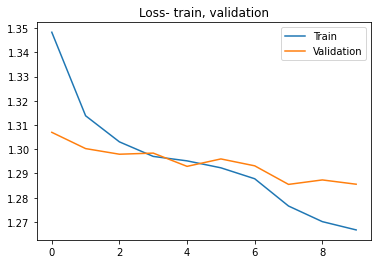

In [ ]:
plt.plot(results['train_loss'], label="Train")
plt.plot(results['test_loss'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

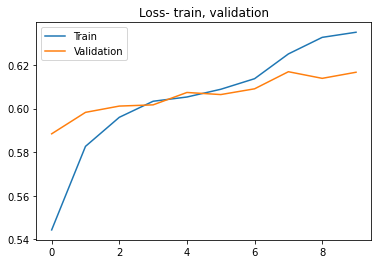

In [ ]:
plt.plot(results['train_acc'], label="Train")
plt.plot(results['test_acc'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

#### Embedding random weights

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model_random = CnnTextClassifier(embedding_weights=embedding_weights, kernel_sizes=[3, 4, 5], dim=300, num_classes=5, 
                                     to_freeze=False, random_weights=True).to(device)
cnn_model_random

CnnTextClassifier(
  (embedding): Embedding(11431, 300)
  (conv_0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
  (conv_1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  (fc): Linear(in_features=192, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = torch.optim.Adam(cnn_model_random.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
cnn_model_random, results = train_model(cnn_model_random, dataloaders, criterion,optimizer_ft, 
                                 exp_lr_scheduler,num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.4424 Acc: 0.4439
val Loss: 1.3922 Acc: 0.5024

Epoch 1/9
----------
train Loss: 1.3889 Acc: 0.5058
val Loss: 1.3636 Acc: 0.5341

Epoch 2/9
----------
train Loss: 1.3675 Acc: 0.5296
val Loss: 1.3498 Acc: 0.5479

Epoch 3/9
----------
train Loss: 1.3500 Acc: 0.5489
val Loss: 1.3276 Acc: 0.5704

Epoch 4/9
----------
train Loss: 1.3393 Acc: 0.5605
val Loss: 1.3272 Acc: 0.5732

Epoch 5/9
----------
train Loss: 1.3305 Acc: 0.5699
val Loss: 1.3231 Acc: 0.5777

Epoch 6/9
----------
train Loss: 1.3167 Acc: 0.5845
val Loss: 1.3184 Acc: 0.5832

Epoch 7/9
----------
train Loss: 1.2980 Acc: 0.6026
val Loss: 1.3060 Acc: 0.5958

Epoch 8/9
----------
train Loss: 1.2914 Acc: 0.6101
val Loss: 1.3056 Acc: 0.5956

Epoch 9/9
----------
train Loss: 1.2905 Acc: 0.6107
val Loss: 1.3029 Acc: 0.5976

Training complete in 1m 38s
Best val Acc: 0.597647


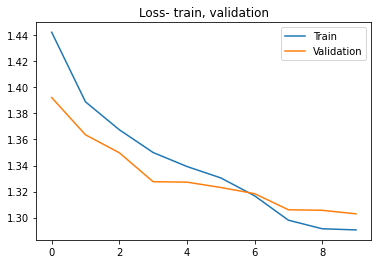

In [ ]:
plt.plot(results['train_loss'], label="Train")
plt.plot(results['test_loss'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

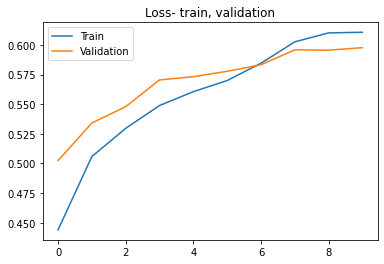

In [ ]:
plt.plot(results['train_acc'], label="Train")
plt.plot(results['test_acc'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()